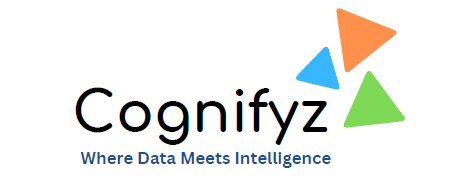

##### NAME - ASHWIN SURESH
##### DOMAIN - MACHINE LEARNING
##### Ref. : CTI/A1/C127540

---


# Task 4: Location-Based Analysis

This notebook performs a comprehensive geographical analysis of restaurants, following these steps:

1. Data Load & Quality Checks
2. Exploratory Data Analysis (EDA)
3. Preprocessing & Coordinate Scaling
4. Spatial Clustering & Comparison
5. Best Cluster Assignment
6. Advanced Geospatial Visualizations
7. City-Level Summary Statistics
8. Final Interpretation & Business Insights

---
---

## 1. Data Load & Quality Checks

---

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
rest_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')

Mounted at /content/drive


---

In [2]:
display(rest_data.head())

Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, Mandaluyong City   
3      SM Megamall, Ortigas, Mandaluyong City   
4      SM Megamall, Ortigas, Mandaluyong City   

                                    Locality Verbose   Longitude   Latitude  \
0  Century City Mall, Poblacion, Makati City, Mak...  121.027535  14.565443   
1  Little Tokyo, Legaspi Village, Makati City, Ma...  121.014101  14.553708   
2  Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...  121.056831  14.581404   
3  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.056475  14.585318   
4  SM Megamall, Ortigas, Mandaluyong City, Mandal...  121.057508  14.584450   

                           Cuisines  ...          Currency Has Table booking  \
0        French, Japanese, Desserts  ...  Botswana Pula(P)               Yes   
1                          Japanese  ...  Botswana Pula(P)               Yes   
2  Seafood, Asian, Filipino, Indian  ...  Botswana Pula(P)               Yes   
3                   Japanese, Sushi  ...  Botswana Pula(P)                No   
4                  Japanese, Korean  ...  Botswana Pula(P)               Yes   

  Has Online delivery Is delivering now Switch to order menu Price range  \
0                  No                No                   No           3   
1                  No                No                   No           3   
2                  No                No                   No           4   
3                  No                No                   No           4   
4                  No                No                   No           4   

   Aggregate rating  Rating color Rating text Votes  
0               4.8    Dark Green   Excellent   314  
1               4.5    Dark Green   Excellent   591  
2               4.4         Green   Very Good   270  
3               4.9    Dark Green   Excellent   365  
4               4.8    Dark Green   Excellent   229  

[5 rows x 21 columns]

---

In [5]:
# Convert lat/lon to numeric and drop invalid
rest_data['Latitude'] = pd.to_numeric(rest_data['Latitude'], errors='coerce')
rest_data['Longitude'] = pd.to_numeric(rest_data['Longitude'], errors='coerce')
print("Before drop:", rest_data.shape)

Before drop: (9551, 21)


---

In [7]:
rest_data = rest_data.dropna(subset=['Latitude','Longitude']).reset_index(drop=True)
print("After dropping missing coords:", rest_data.shape)
print("Duplicate IDs:", rest_data['Restaurant ID'].duplicated().sum())

After dropping missing coords: (9551, 21)
Duplicate IDs: 0


---

In [8]:
# Data types & non-null counts
print("DataFrame info:")
rest_data.info()
print("\n")

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switc

---

In [9]:
# Unique-value counts for object columns
print("Unique values in object columns:")
for col in rest_data.select_dtypes(include=['object']).columns:
    print(f"  {col:25}: {rest_data[col].nunique():4} unique")

Unique values in object columns:
  Restaurant Name          : 7446 unique
  City                     :  141 unique
  Address                  : 8918 unique
  Locality                 : 1208 unique
  Locality Verbose         : 1265 unique
  Cuisines                 : 1825 unique
  Currency                 :   12 unique
  Has Table booking        :    2 unique
  Has Online delivery      :    2 unique
  Is delivering now        :    2 unique
  Switch to order menu     :    1 unique
  Rating color             :    6 unique
  Rating text              :    6 unique


---

In [10]:
# Rating sanity check
print("\nRating range:", rest_data['Aggregate rating'].min(), "to", rest_data['Aggregate rating'].max())
print("Counts of negative or zero ratings:", (rest_data['Aggregate rating'] <= 0).sum())


Rating range: 0.0 to 4.9
Counts of negative or zero ratings: 2148


---

In [11]:
# Numeric summary & outlier alerts
num_summary = rest_data[['Price range','Votes','Longitude','Latitude','Aggregate rating']].describe()
display(num_summary)

Price range         Votes    Longitude     Latitude  Aggregate rating
count  9551.000000   9551.000000  9551.000000  9551.000000       9551.000000
mean      1.804837    156.909748    64.126574    25.854381          2.666370
std       0.905609    430.169145    41.467058    11.007935          1.516378
min       1.000000      0.000000  -157.948486   -41.330428          0.000000
25%       1.000000      5.000000    77.081343    28.478713          2.500000
50%       2.000000     31.000000    77.191964    28.570469          3.200000
75%       2.000000    131.000000    77.282006    28.642758          3.700000
max       4.000000  10934.000000   174.832089    55.976980          4.900000

---
---

## 2. Exploratory Data Analysis (EDA)

---

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

---

<ipython-input-16-e6f046c3ab52>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.values, y=city_counts.index, palette='viridis')


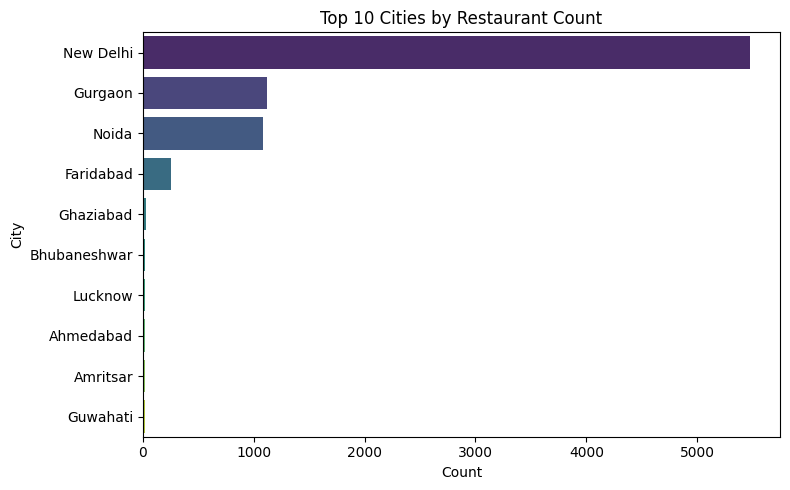

In [16]:
# Top cities
city_counts = rest_data['City'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=city_counts.values, y=city_counts.index, palette='viridis')
plt.title('Top 10 Cities by Restaurant Count')
plt.xlabel('Count'); plt.ylabel('City'); plt.tight_layout(); plt.show()

---

<ipython-input-17-469379fa563b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='City', y='Aggregate rating', data=rest_data[rest_data['City'].isin(top_cities)], palette='Set2')


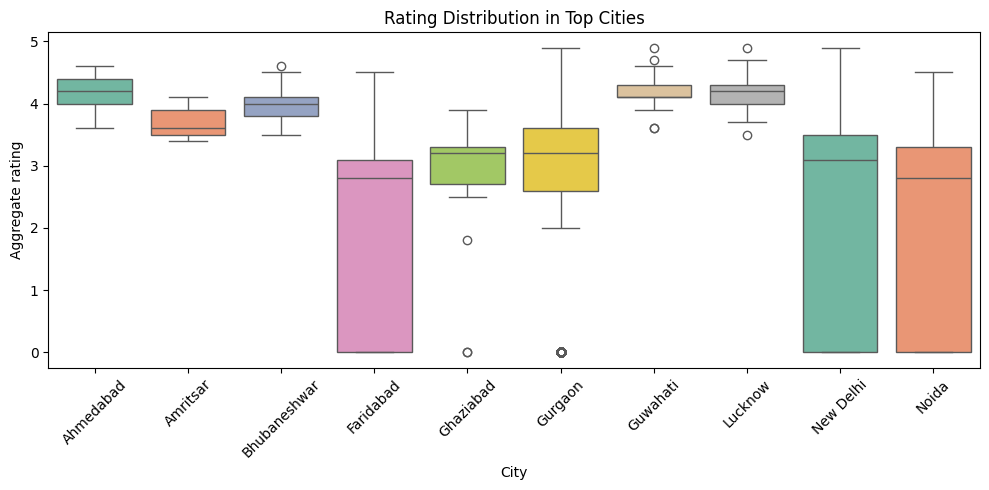

In [17]:
top_cities = city_counts.index.tolist()
plt.figure(figsize=(10,5))
sns.boxplot(x='City', y='Aggregate rating', data=rest_data[rest_data['City'].isin(top_cities)], palette='Set2')
plt.xticks(rotation=45); plt.title('Rating Distribution in Top Cities'); plt.tight_layout(); plt.show()


---

<ipython-input-22-c8467d9e8e9c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rest_data[rest_data['City'].isin(top_cities)], x='City', y='Average Cost for two', palette='Spectral')


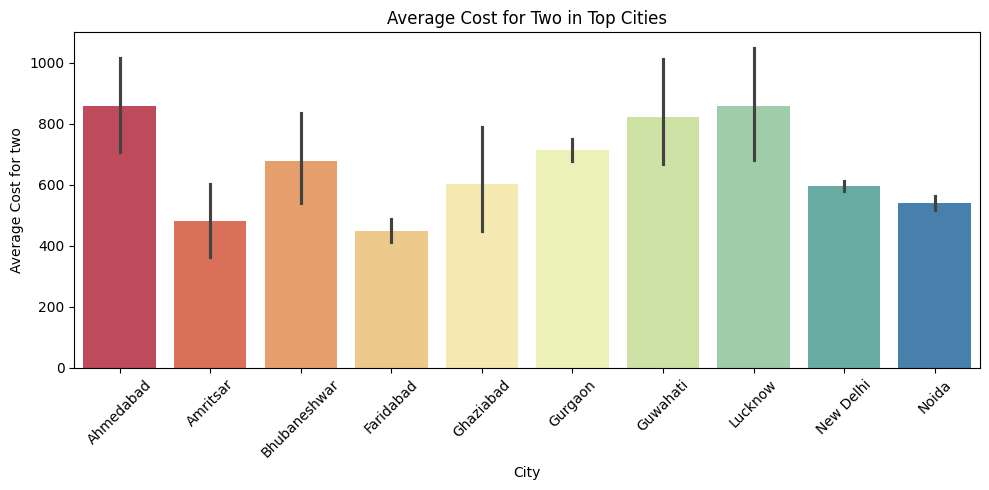

In [22]:
# 2.3 Average cost comparison by city
plt.figure(figsize=(10,5))
sns.barplot(data=rest_data[rest_data['City'].isin(top_cities)], x='City', y='Average Cost for two', palette='Spectral')
plt.xticks(rotation=45); plt.title('Average Cost for Two in Top Cities'); plt.tight_layout(); plt.show()

---

<ipython-input-26-d54cb4852c63>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rest_data[rest_data['City'].isin(top_cities)], x='Price range', palette='autumn')


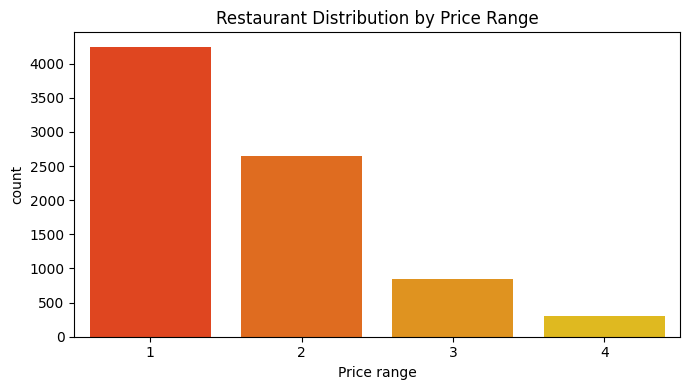

In [26]:
# Distribution of restaurants by price range
plt.figure(figsize=(7,4))
sns.countplot(data=rest_data[rest_data['City'].isin(top_cities)], x='Price range', palette='autumn')
plt.title('Restaurant Distribution by Price Range'); plt.tight_layout(); plt.show()

---
---

## 3. Preprocessing & Coordinate Scaling

---

In [34]:
from sklearn.preprocessing import StandardScaler
coords = rest_data[['Latitude','Longitude']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

---
---

## 4. Spatial Clustering & Comparison

---

In [39]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, OPTICS
from sklearn.metrics import silhouette_score

clustering_results = {}

---

In [40]:
# KMeans
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans_model.fit_predict(coords_scaled)
kmeans_score = silhouette_score(coords_scaled, kmeans_labels)
clustering_results['KMeans (k=5)'] = kmeans_score

---

In [41]:
# DBSCAN
dbscan_model = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan_model.fit_predict(coords_scaled)
dbscan_score = silhouette_score(coords_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
clustering_results['DBSCAN'] = dbscan_score

---

In [42]:
# Agglomerative Clustering
agglo_model = AgglomerativeClustering(n_clusters=5)
agglo_labels = agglo_model.fit_predict(coords_scaled)
agglo_score = silhouette_score(coords_scaled, agglo_labels)
clustering_results['Agglomerative (k=5)'] = agglo_score

---

In [43]:
# MeanShift
meanshift_model = MeanShift()
meanshift_labels = meanshift_model.fit_predict(coords_scaled)
meanshift_score = silhouette_score(coords_scaled, meanshift_labels) if len(set(meanshift_labels)) > 1 else -1
clustering_results['MeanShift'] = meanshift_score

---

In [44]:
# OPTICS
optics_model = OPTICS(min_samples=10)
optics_labels = optics_model.fit_predict(coords_scaled)
optics_score = silhouette_score(coords_scaled, optics_labels) if len(set(optics_labels)) > 1 else -1
clustering_results['OPTICS'] = optics_score

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


---

<ipython-input-45-3e7b3444b2e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(clustering_results.keys()), y=list(clustering_results.values()), palette='coolwarm')


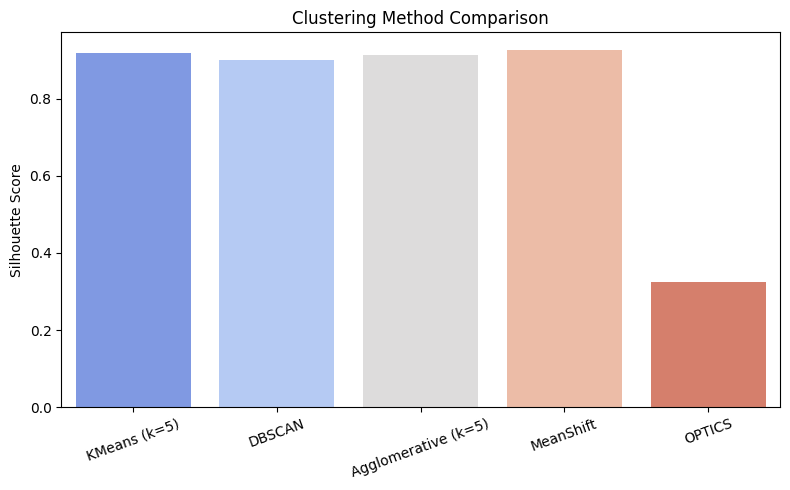

In [45]:
# Visualization of comparison
plt.figure(figsize=(8,5))
sns.barplot(x=list(clustering_results.keys()), y=list(clustering_results.values()), palette='coolwarm')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=20)
plt.title('Clustering Method Comparison')
plt.tight_layout()
plt.show()

---

In [46]:
# Select best method based on score
best_method = max(clustering_results, key=clustering_results.get)
print(f"Best clustering method based on silhouette score: {best_method}")

Best clustering method based on silhouette score: MeanShift


---

In [47]:
# Store best labels for use in later visualizations
best_labels = {
    'KMeans (k=5)': kmeans_labels,
    'DBSCAN': dbscan_labels,
    'Agglomerative (k=5)': agglo_labels,
    'MeanShift': meanshift_labels,
    'OPTICS': optics_labels
}[best_method]

rest_data['Best_Cluster'] = best_labels

---
---

## 5. Best Cluster Assignment

---

In [49]:
from sklearn.cluster import MeanShift
meanshift_model = MeanShift()
meanshift_labels = meanshift_model.fit_predict(coords_scaled)
rest_data['Best_Cluster'] = meanshift_labels

---
---

## 6. Advanced Geospatial Visualizations

---

In [50]:
import folium
from folium.plugins import MarkerCluster

---

In [52]:
# 6.1 Folium map with marker clusters
m = folium.Map(location=[rest_data['Latitude'].mean(), rest_data['Longitude'].mean()], zoom_start=12)
mc = MarkerCluster().add_to(m)
unique_clusters = np.unique(rest_data['Best_Cluster'])
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
color_map = {label: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for label, (r, g, b, _) in zip(unique_clusters, colors)}

for _, row in rest_data.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=3,
        color=color_map[row['Best_Cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(mc)
m  # display map

---

In [54]:
# 6.2 Global scatter with Plotly
import plotly.express as px
fig = px.scatter_geo(rest_data, lat='Latitude', lon='Longitude', color='Best_Cluster',
                     hover_name='Restaurant Name', scope='asia')
fig.update_layout(title='Restaurant Locations by Best Cluster (MeanShift)')
fig.show()

---

In [55]:
sample_size = min(2000, len(rest_data))
map_data = rest_data.sample(sample_size) if len(rest_data) > sample_size else rest_data

fig = px.scatter_geo(
    map_data,
    lat="Latitude",
    lon="Longitude",
    color="Aggregate rating",
    hover_name="Restaurant Name",
    hover_data=["Cuisines", "City", "Price range"],
    projection="natural earth",
    title="Global Restaurant Distribution (Sample)",
    color_continuous_scale=px.colors.sequential.Viridis,
    size_max=15
)


fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="rgb(212, 212, 212)",
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)",
        showsubunits=True,
        showcountries=True,
        showocean=True,
        oceancolor="rgb(230, 230, 250)"
    ),
    height=600,
    margin={"r":0,"t":40,"l":0,"b":0}
)


fig.show()

---

In [57]:

city_stats = rest_data.groupby('City').agg({
    'Restaurant ID': 'count',
    'Aggregate rating': 'mean',
    'Price range': 'mean',
    'Average Cost for two': 'mean',
    'Votes': 'mean'
}).rename(columns={'Restaurant ID': 'Restaurant Count'}).reset_index()


city_stats = city_stats.sort_values('Restaurant Count', ascending=False)


print("Top 15 cities by restaurant count:")
city_stats.head(15)
top_city = city_stats.iloc[0]['City']
print(f"Creating detailed map for {top_city} with {len(rest_data[rest_data['City'] == top_city])} restaurants")


city_data = rest_data[rest_data['City'] == top_city].copy()

lat_q1 = city_data['Latitude'].quantile(0.25)
lat_q3 = city_data['Latitude'].quantile(0.75)
lat_iqr = lat_q3 - lat_q1
lat_lower = lat_q1 - 1.5 * lat_iqr
lat_upper = lat_q3 + 1.5 * lat_iqr

lng_q1 = city_data['Longitude'].quantile(0.25)
lng_q3 = city_data['Longitude'].quantile(0.75)
lng_iqr = lng_q3 - lng_q1
lng_lower = lng_q1 - 1.5 * lng_iqr
lng_upper = lng_q3 + 1.5 * lng_iqr


city_data_filtered = city_data[
    (city_data['Latitude'] >= lat_lower) &
    (city_data['Latitude'] <= lat_upper) &
    (city_data['Longitude'] >= lng_lower) &
    (city_data['Longitude'] <= lng_upper)
]

print(f"Removed {len(city_data) - len(city_data_filtered)} outlier coordinates")
print(f"Remaining restaurants with valid coordinates: {len(city_data_filtered)}")


if len(city_data_filtered) > 0:

    center_lat = city_data_filtered['Latitude'].median()
    center_lng = city_data_filtered['Longitude'].median()

    print(f"Map will be centered at: Lat {center_lat}, Lng {center_lng}")


    fig = px.scatter_mapbox(
        city_data_filtered,
        lat="Latitude",
        lon="Longitude",
        color="Aggregate rating",
        size="Votes",
        size_max=15,
        hover_name="Restaurant Name",
        hover_data=["Cuisines", "Price range", "Average Cost for two", "Rating text"],
        color_continuous_scale=px.colors.sequential.Viridis,
        zoom=10,
        mapbox_style="open-street-map",
        center={"lat": center_lat, "lon": center_lng}
    )

    fig.update_layout(
        title=f'Interactive Map of Restaurants in {top_city}',
        height=600,
        margin={"r":0,"t":50,"l":0,"b":0}
    )


    fig.show()


    fig_city_density = px.density_mapbox(
        city_data_filtered,
        lat='Latitude',
        lon='Longitude',
        z='Aggregate rating',
        radius=15,
        zoom=10,
        mapbox_style="open-street-map",
        title=f"Restaurant Rating Density in {top_city}",
        center={"lat": center_lat, "lon": center_lng}
    )

    fig_city_density.update_layout(height=600, margin={"r":0,"t":50,"l":0,"b":0})
    fig_city_density.show()
else:
    print("No valid coordinate data available for mapping after filtering outliers")

Top 15 cities by restaurant count:
Creating detailed map for New Delhi with 5473 restaurants
Removed 272 outlier coordinates
Remaining restaurants with valid coordinates: 5201
Map will be centered at: Lat 28.627832, Lng 77.2065181


---
---

## 7. City-Level Summary Statistics

---

count  avg_rating  avg_price
City                                      
New Delhi      5473    2.438845   1.621597
Gurgaon        1118    2.651431   1.855993
Noida          1080    2.036204   1.601852
Faridabad       251    1.866932   1.454183
Ghaziabad        25    2.852000   1.800000
Bhubaneshwar     21    3.980952   1.857143
Lucknow          21    4.195238   2.571429
Guwahati         21    4.190476   2.523810
Ahmedabad        21    4.161905   2.571429
Amritsar         21    3.685714   1.809524

<ipython-input-59-d5d5d417fadb>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




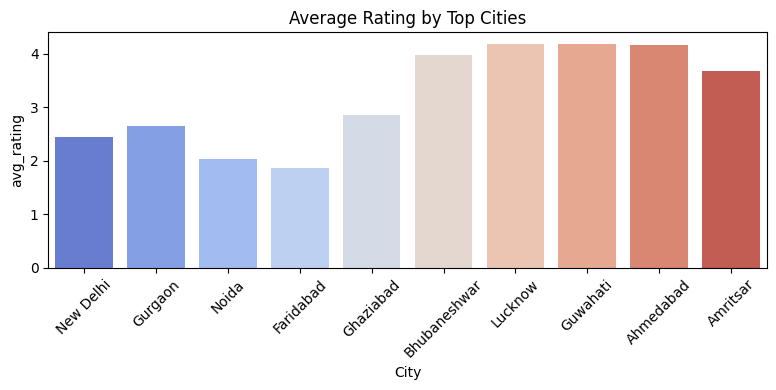

In [59]:
city_stats = rest_data.groupby('City').agg(
    count=('Restaurant ID','size'),
    avg_rating=('Aggregate rating','mean'),
    avg_price=('Price range','mean')
).sort_values('count', ascending=False).head(10)

# Display table and bar chart
display(city_stats)
plt.figure(figsize=(8,4))
sns.barplot(x=city_stats.index, y='avg_rating', data=city_stats.reset_index(), palette='coolwarm')
plt.title('Average Rating by Top Cities'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


---

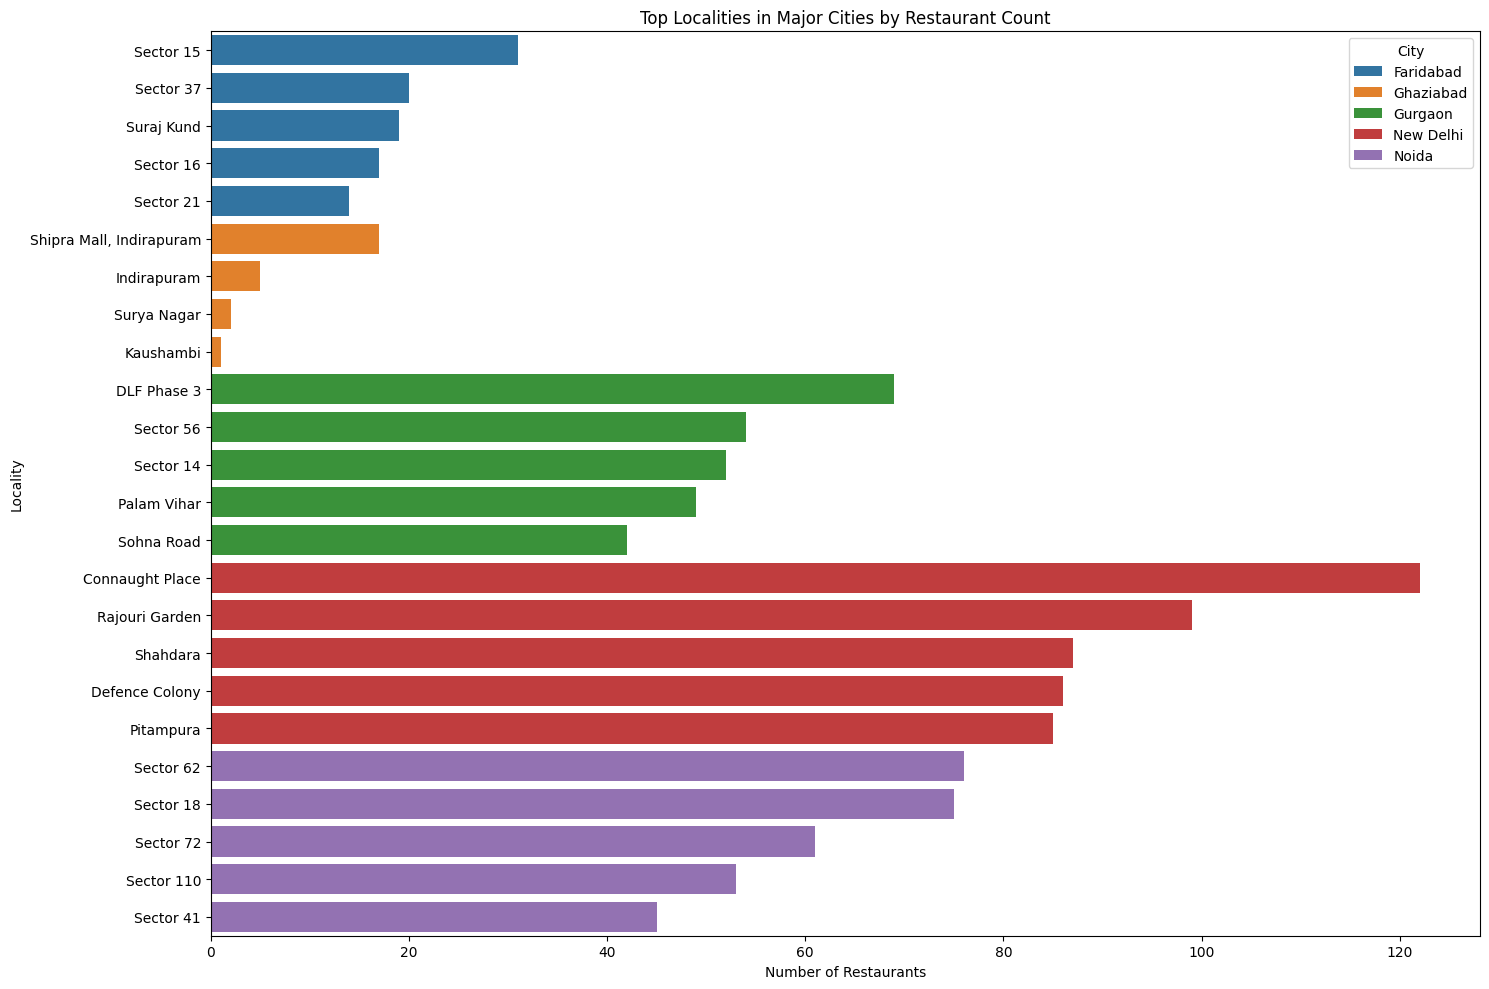

In [ ]:
# Group restaurants by locality and count
locality_counts = rest_data.groupby(['City', 'Locality']).size().reset_index(name='Restaurant Count')

# Get top localities in each city
top_localities = locality_counts.sort_values(['City', 'Restaurant Count'], ascending=[True, False])
top_localities_per_city = top_localities.groupby('City').head(5)

# Plot for top 5 cities
top_5_cities = city_stats.head(5)['City'].tolist()
top_localities_in_major_cities = top_localities_per_city[top_localities_per_city['City'].isin(top_5_cities)]

plt.figure(figsize=(15, 10))
sns.barplot(x='Restaurant Count', y='Locality', hue='City', data=top_localities_in_major_cities)
plt.title('Top Localities in Major Cities by Restaurant Count')
plt.xlabel('Number of Restaurants')
plt.ylabel('Locality')
plt.tight_layout()
plt.show()

---

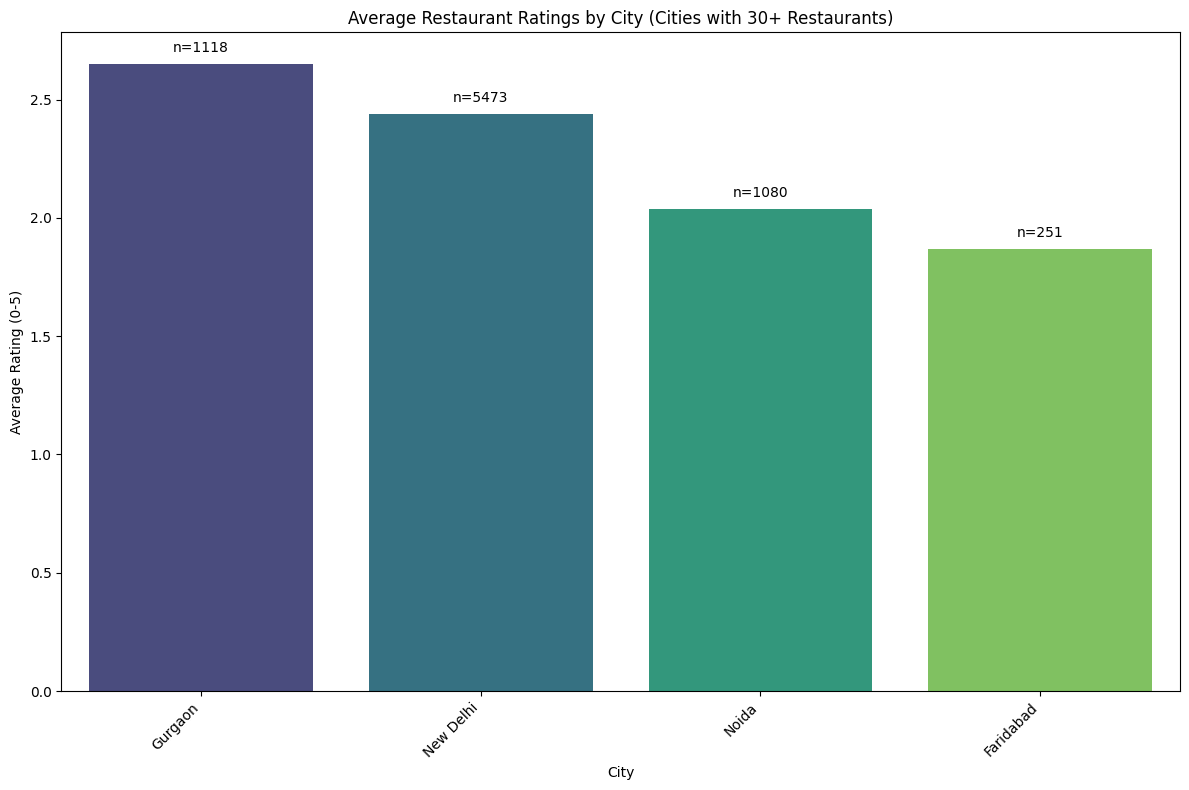

In [ ]:
top_rated_cities = city_stats[city_stats['Restaurant Count'] >= 30].sort_values('Aggregate rating', ascending=False).head(15)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='City', y='Aggregate rating', data=top_rated_cities, palette='viridis')
plt.title('Average Restaurant Ratings by City (Cities with 30+ Restaurants)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('City')
plt.ylabel('Average Rating (0-5)')

# Add the count as text on top of each bar
for i, row in enumerate(top_rated_cities.itertuples()):
    ax.text(i, row._3 + 0.05, f'n={int(row._2)}', ha='center')

plt.tight_layout()
plt.show()

---

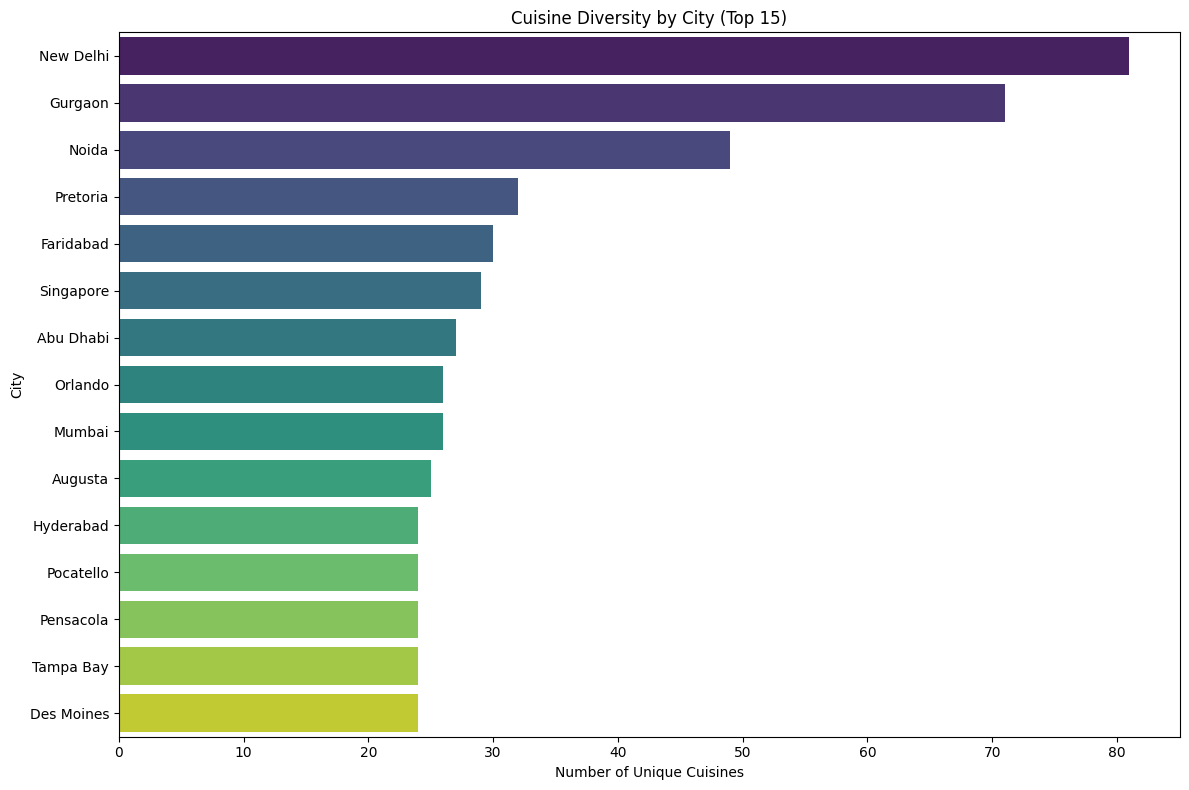

In [ ]:
def count_unique_cuisines(group):
    all_cuisines = []
    for cuisines in group['Cuisines']:
        if isinstance(cuisines, str) and cuisines != 'Unknown':
            all_cuisines.extend([c.strip() for c in cuisines.split(',')])
    return len(set(all_cuisines))

cuisine_diversity = rest_data.groupby('City').apply(count_unique_cuisines).reset_index(name='Unique Cuisines')
cuisine_diversity = cuisine_diversity.sort_values('Unique Cuisines', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Unique Cuisines', y='City', data=cuisine_diversity.head(15), palette='viridis')
plt.title('Cuisine Diversity by City (Top 15)')
plt.xlabel('Number of Unique Cuisines')
plt.ylabel('City')
plt.tight_layout()
plt.show()

---

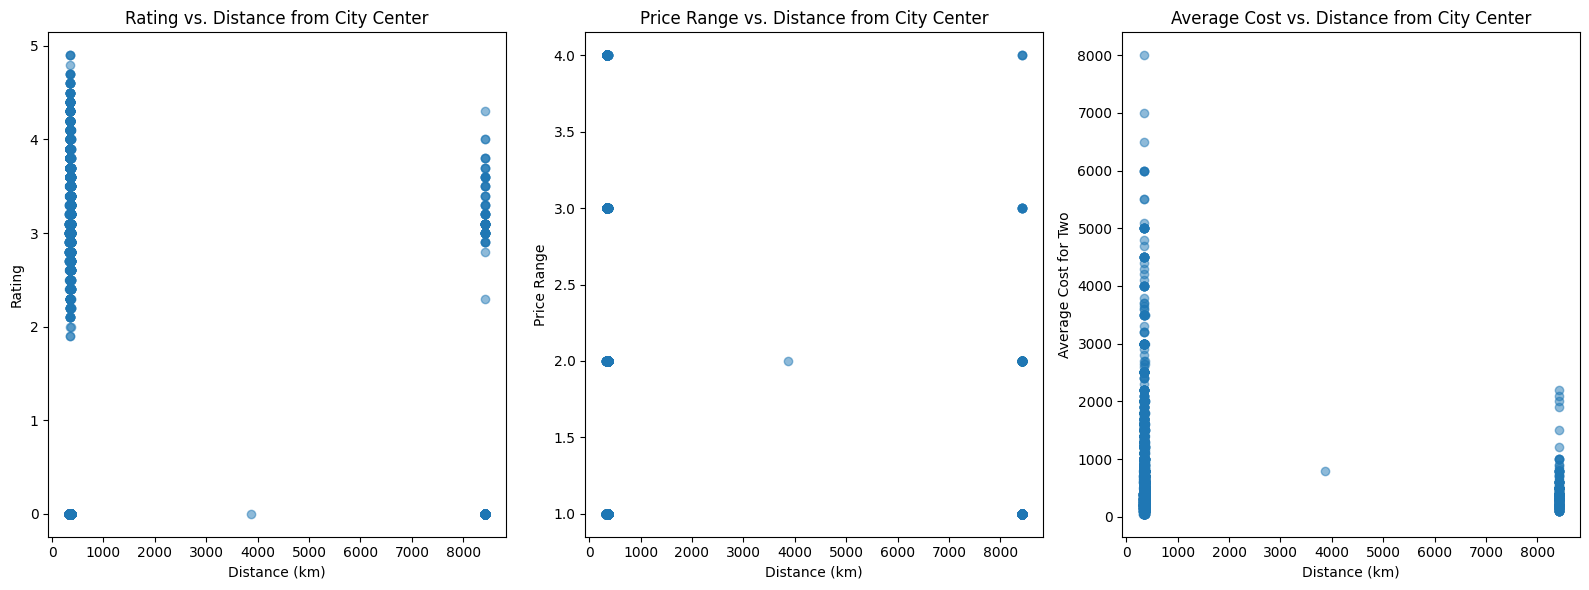

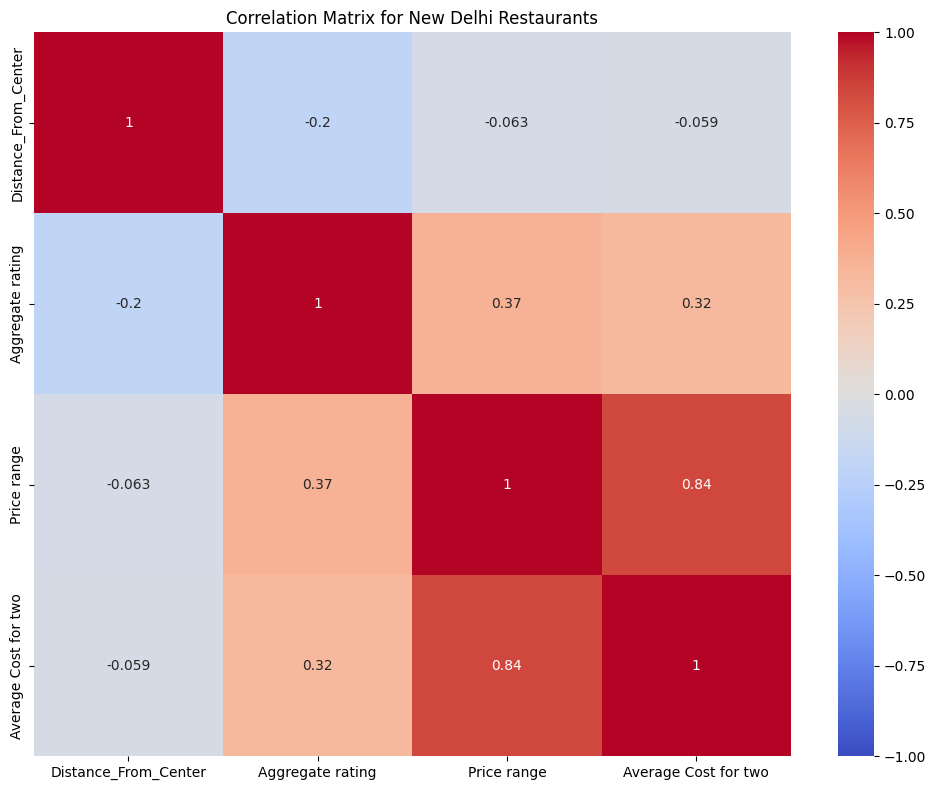

In [ ]:
if len(city_data) > 0:
    city_center = (city_data['Latitude'].mean(), city_data['Longitude'].mean())

    def haversine_distance(lat, lon, center_lat, center_lon):
        lat, lon, center_lat, center_lon = map(np.radians, [lat, lon, center_lat, center_lon])

        # Haversine formula
        dlon = lon - center_lon
        dlat = lat - center_lat
        a = np.sin(dlat/2)**2 + np.cos(lat) * np.cos(center_lat) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371  # Radius of Earth in kilometers
        return c * r

    city_data['Distance_From_Center'] = city_data.apply(
        lambda row: haversine_distance(row['Latitude'], row['Longitude'],
                                       city_center[0], city_center[1]), axis=1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.scatter(city_data['Distance_From_Center'], city_data['Aggregate rating'], alpha=0.5)
    plt.title('Rating vs. Distance from City Center')
    plt.xlabel('Distance (km)')
    plt.ylabel('Rating')

    plt.subplot(1, 3, 2)
    plt.scatter(city_data['Distance_From_Center'], city_data['Price range'], alpha=0.5)
    plt.title('Price Range vs. Distance from City Center')
    plt.xlabel('Distance (km)')
    plt.ylabel('Price Range')

    plt.subplot(1, 3, 3)
    plt.scatter(city_data['Distance_From_Center'], city_data['Average Cost for two'], alpha=0.5)
    plt.title('Average Cost vs. Distance from City Center')
    plt.xlabel('Distance (km)')
    plt.ylabel('Average Cost for Two')

    plt.tight_layout()
    plt.show()

    # Calculate correlation
    corr_data = city_data[['Distance_From_Center', 'Aggregate rating', 'Price range', 'Average Cost for two']]
    correlation = corr_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {top_city} Restaurants')
    plt.tight_layout()
    plt.show()

---
---

## 8. Final Interpretation & Business Insights

---


1. Total restaurants analyzed: 9551
2. Total cities represented: 141
3. City with most restaurants: New Delhi (5473)
4. Highest rated city (min. 30 restaurants): Gurgaon (avg. rating: 2.65/5)
5. City with most cuisine diversity: New Delhi (81 unique cuisines)
6. Correlation between distance from center and rating in New Delhi: -0.20
7. Correlation between distance from center and cost in New Delhi: -0.06


• Restaurant distribution is highly concentrated in urban areas.

• There appears to be variation in restaurant ratings across different cities.

• Price ranges and average costs differ significantly between cities.

• Major cities tend to have greater cuisine diversity.

---
---
---